# ---------------------------------------------------------------------------------------------------------------
#
#         R Script to Download and Graph USGS Stream Temperature data from the Upper Columbia
#            Author: Ryan Niemeyer, Watershed Program Manager at the Upper Columbia Salmon Recovery Board
#            Date: Fall 2020
#
# ---------------------------------------------------------------------------------------------------------------

In [4]:
# ------------------ Year to Plot ------------------
year_to_plot = 2019
# --------------- Pathway to Output Figure --------------
path_output = 'Y:/Ryan/Misc/Annual_Report/2019/usgs_stream_temperature_graph.pdf'

In [5]:
library(data.table)

In [308]:
USGS_site = 'Y:/Science/DATA/USGS/Upper_Columbia_USGS_stream_temperature_sites_to_analyze.csv'
USGS_sites = read.csv(USGS_site, header=T)

In [309]:
USGS_sites

USGS_site_no,Site_name,City,subbasin
<int>,<chr>,<chr>,<chr>
12442500,"SIMILKAMEEN RIVER NEAR NIGHTHAWK, WA",Nighthawk,Okanogan
12447200,"OKANOGAN RIVER AT MALOTT, WA",Malott,Okanogan
12447390,"ANDREWS CREEK NEAR MAZAMA, WA",Mazama,Methow
12450480,"METHOW RIVER NEAR PATEROS, WA",Pateros,Methow
12462500,"WENATCHEE RIVER AT MONITOR, WA",Monitor,Wenatchee


In [8]:

# ---------------- water year function ----------
wtr_yr <- function(dates, start_month=10) {
  # Convert dates into POSIXlt
  dates.posix = as.POSIXlt(dates)
  # Year offset
  offset = ifelse(dates.posix$mon >= start_month - 1, 1, 0)
  # Water year
  adj.year = dates.posix$year + 1900 + offset
  # Return the water year
  adj.year
}

In [300]:
deg_C_to_deg_F = function(temp_x){
    
    temp_x = (temp_x * 1.8) + 32
    return(temp_x)
    
}

In [30]:
movingAverage <- function(x, n=1, centered=FALSE) {
    
    if (centered) {
        before <- floor  ((n-1)/2)
        after  <- ceiling((n-1)/2)
    } else {
        before <- n-1
        after  <- 0
    }

    # Track the sum and count of number of non-NA items
    s     <- rep(0, length(x))
    count <- rep(0, length(x))
    
    # Add the centered data 
    new <- x
    # Add to count list wherever there isn't a 
    count <- count + !is.na(new)
    # Now replace NA_s with 0_s and add to total
    new[is.na(new)] <- 0
    s <- s + new
    
    # Add the data from before
    i <- 1
    while (i <= before) {
        # This is the vector with offset values to add
        new   <- c(rep(NA, i), x[1:(length(x)-i)])

        count <- count + !is.na(new)
        new[is.na(new)] <- 0
        s <- s + new
        
        i <- i+1
    }

    # Add the data from after
    i <- 1
    while (i <= after) {
        # This is the vector with offset values to add
        new   <- c(x[(i+1):length(x)], rep(NA, i))
       
        count <- count + !is.na(new)
        new[is.na(new)] <- 0
        s <- s + new
        
        i <- i+1
    }
    
    # return sum divided by count
    s/count
}


In [287]:

# -------------------------- FUNCTION to calculate median flow ------------------------

median_stream_temperature_function = function(metric_vector, date_vector, year_for_days){
    
    # --------------------- get day of year ---------------
    day_of_year =  format(date_vector, format="%j")
    
    # ----------------------- get median for that day of year -------------
    data_x = as.data.frame(cbind(day_of_year, metric_vector))
    data_x$metric_vector = as.numeric(data_x$metric_vector)
    median_x = aggregate(data_x$metric_vector, list(data_x$day_of_year), FUN=median, na.rm=TRUE, na.action = NULL)
    colnames(median_x) = c('day_of_year', 'metric')
    
    # -------------------- remove day 366 (from leap year) ------------
    median_x = median_x[1:365,]
    
    # ------------- add day of hydrologic year --------------
    median_x$day_of_hydro_year = median_x$day_of_year
    
    # ---------- days after Oct. 1 -------------
    days_previous_calendar_year = which(median_x$day_of_year > 274)
    median_x$day_of_hydro_year[days_previous_calendar_year] = paste(median_x$day_of_hydro_year[days_previous_calendar_year], year_for_days - 1, sep="-")
    
    # ---------- days before Oct. 1 -------------
    days_during_calendar_year = which(median_x$day_of_year <= 274)
    median_x$day_of_hydro_year[days_during_calendar_year] = paste(median_x$day_of_hydro_year[days_during_calendar_year], year_for_days, sep="-")
    # --------------- get date time -------------
    median_x$day_of_hydro_year =  as.POSIXct(median_x$day_of_hydro_year, format="%j-%Y",tz="America/Los_Angeles")
    
    # ----------------- return the data ------------------
    return(median_x)
    
}


In [279]:
print(i)
print(USGS_sites$USGS_site_no[i])
# ------------------------ generate the median snotel -------------------
stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'stream_temperature_degC' ))
date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime2'
#date_vector = as.POSIXct(date_vector, format="%Y-%m-%d") #  convert to date time 
metric_vector = stream_temperature_data_x

# --------------------- get day of year ---------------
day_of_year =  format(date_vector, format="%j")

# ----------------------- get median for that day of year -------------
data_x = as.data.frame(cbind(day_of_year, metric_vector))
colnames(data_x)
data_x$metric_vector = as.numeric(data_x$metric_vector)

# ------------------------ generate the median snotel -------------------
# median_stream_temperature_data_x = median_stream_temperature_function(stream_temperature_data_x, date_vector, year_to_plot)


[1] 1
[1] 12442500


[1] "day_of_year"   "metric_vector"

In [275]:
length(metric_vector)

ERROR: Error in eval(expr, envir, enclos): object 'metric_vector' not found


In [118]:

# ---------------------------------------------------------------------------------------------------
#          Download USGS data 
# ---------------------------------------------------------------------------------------------------

FXN_download_stream_temperature = function(site_x, start_date_x, end_date_x, use_provisional, metric_to_plot){
    
    # ------ choose column to plot based on metric ----------
    if(metric_to_plot == 'mean'){colx = 8}
    if(metric_to_plot == 'max'){colx = 4}
    if(metric_to_plot == 'min'){colx = 6}    
    if(metric_to_plot == 'mean2'){colx = 14}
    if(metric_to_plot == 'max2'){colx = 10}
    if(metric_to_plot == 'min2'){colx = 12} 
    
    # ------------ set up conversions ----------
    #ft3_to_mm3 = 2.832e+7
    sec_to_day = 86400
    #mi2_to_ft2 = 27878400
    #mi2_to_mm2 = 2589988110000

    # --------- re-calculate area -------
    #area_catchment_sq_ft = area_catchment_sq_miles * mi2_to_ft2  # convert square miles to square feet
    #area_catchment_sq_mm = area_catchment_sq_miles * mi2_to_mm2  # convert square miles to square mm

    # ---------- Update path ----------
    path_origx = 'https://waterdata.usgs.gov/nwis/dv?cb_00010=on&format=rdb&site_no=SITE_NUMBER&referred_module=sw&period=&begin_date=START_DATE&end_date=END_DATE'
    path_updated_x = gsub('SITE_NUMBER', site_x, path_origx)
    path_updated_x = gsub('START_DATE', start_date_x, path_updated_x)
    path_updated_x = gsub('END_DATE', end_date_x, path_updated_x)

    # ------------ Download Data ----------
    datax = fread(path_updated_x)
    datax = as.data.frame(datax)
    datax = datax[c(3:nrow(datax)),]  # remove the first two rows that aren't data

    # ----- use provisional or not --------
    if(use_provisional == TRUE){
        datax2 = datax[,c(3,colx)]
    }else{
        x = which(datax[,colx+1]=='A')  # A is that means it's been processed, P means it is provisonal
        datax2 = datax[x,c(3,colx)]
    }

    # ----- assign names and calculate with updated units -----------
    colnames(datax2) = c('datetime','stream_temperature_degC') # set column mames
    datax2$stream_temperature_degC = as.numeric(as.character(datax2$stream_temperature_degC))   # set as numeric
    #datax2$discharge_mm_day =  datax2$discharge_ft3_sec*sec_to_day*ft3_to_mm3/area_catchment_sq_mm    # convert to mm per day flow

    # ------- set date time ------
    datax2$datetime2 = as.POSIXct(datax2$datetime, format = "%Y-%m-%d", tz='UTC')
    datax2$wtr_yr = wtr_yr(datax2$datetime2, start_month = 10)

    # ---------- output data --------------
    print('dimensions of data:')
    print(dim(datax2))
    return(datax2)
}

In [202]:

# ------------------ FUNCTION to calculate temperature statistics ----------------------


USGS_stream_temperature_statistics = function(stream_temperature_data_x, date_vector, year_to_plot){
    
    # ----------- water year -----------
    date_data_wtr_yr = wtr_yr(date_vector)
    
    # -------- calendar year -------
    date_data_calendar_yr = format(date_vector, '%Y')

    # ---------------------------------------------------------------------------------
    #        Annual peak_temperature statistics          
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual peak 7-day average temperature -----------------
    seven_day_average  = movingAverage(stream_temperature_data_x, n=7)                   # calculate 7-day average temperature (ft3 per sec)
    annual_max = aggregate(seven_day_average, list(date_data_wtr_yr), max, na.rm=TRUE)       # get max 7-day average temperature
    annual_max_year = round( annual_max[which(annual_max[ ,1] == year_to_plot),2], 2)   # peak temperature for the "year to plot"
    mean_annual_max = mean(annual_max[,2], na.rm=T)                   # mean peak temperature across all years
    prcnt_annual_max_year = round((annual_max_year/mean_annual_max) * 100, 2)  # percent difference in year to plot from mean year
    delta_annual_max_year = round((annual_max_year - mean_annual_max), 2)    # the absolute difference between year to plot and average
    
    # -------------- day of annual peak_temperature ---------------
    day_of_annual_max = c()
    unique_years = unique(date_data_wtr_yr)
    for(i in 1:length(unique_years)){

        # ----------------- get peak temperature day for this year -----------------
        year_x = unique_years[i]
        x = which(date_data_wtr_yr == unique_years[i])
        
        # -------------- only use years with at least 300 days -----
        if(length(x) > 300){
            # ----- get data for that year -----
            annual_temperature = seven_day_average[x]
            # -------------- calculate calendar day of peak -----------
            day_of_peak = which(annual_temperature == annual_max[i,2])
            day_of_peak = day_of_peak[1] - 92 # get calendary year day, from water year day
            # ------------------ calculate month and day ---------
            day_of_peak_2 = paste(day_of_peak,  year_x, sep="-")
            day_of_peak_2 = as.Date(day_of_peak_2, format='%j-%Y')
            day_of_peak_2 = format(day_of_peak_2, "%d-%b") # output as day and month
            # ------------- output data --------
            output_row = c(unique_years[i], day_of_peak[1], day_of_peak_2[1])
            day_of_annual_max = rbind(day_of_annual_max, output_row)
        }
    }
    
    # ------------------------- calculate for this year -----------
    peak_temperature_day = as.numeric(day_of_annual_max[which(day_of_annual_max[ ,1] == year_to_plot),2])
    mean_peak_temperature_ALL = round(  ( mean(as.numeric(day_of_annual_max[,2]), na.rm=T) ), 2)
    delta_peak_temperature_day = round(peak_temperature_day - mean_peak_temperature_ALL, 2) # days difference from average
    years_with_enough_data = nrow(day_of_annual_max) 
    
    # ---------------------------------------------------------------------------------
    #        Annual low temperature statistics          
    # ---------------------------------------------------------------------------------

    # ----------------- calculate annual peak snow statistics -----------------
    annual_min = aggregate(seven_day_average, list(date_data_wtr_yr), min, na.rm=TRUE)   # get annual 7-day min each year (ft3 per sec)
    annual_min_year = round( annual_min[which(annual_min[ ,1] == year_to_plot),2], 2)   # annual 7-day min for the year to plot
    mean_annual_min = mean(annual_min[,2], na.rm=T)      # mean annual min 7-day temperature across all years
    prcnt_annual_min_year = round((annual_min_year/mean_annual_min) * 100, 2)    # percent difference in year to plot from mean year
    delta_annual_min_year = round((annual_min_year - mean_annual_min), 2)    # the absolute difference between year to plot and average
    
    # -------------- day of annual low temperature---------------
    day_of_annual_min = c()
    unique_years = unique(date_data_wtr_yr)
    for(i in 1:length(unique_years)){

        # ----------------- get low temperature day for this year -----------------
        year_x = unique_years[i]
        x = which(date_data_wtr_yr == unique_years[i])
        
        # -------------- only use years with at least 300 days -----
        if(length(x) > 300){
            # ----- get data for that year -----
            annual_temperature = seven_day_average[x]
            # -------------- calculate calendar day of low temperature -----------
            day_of_low = which(annual_temperature == annual_min[i,2])
            day_of_low = day_of_low[1] - 92 # get calendary year day, from water year day
            # ------------------ calculate month and day ---------
            day_of_low_2 = paste(day_of_low,  year_x, sep="-")
            day_of_low_2 = as.Date(day_of_low_2, format='%j-%Y')
            day_of_low_2 = format(day_of_low_2, "%d-%b") # output as day and month
            # ------------- output data --------
            output_row = c(unique_years[i], day_of_low[1], day_of_low_2[1])
            day_of_annual_min = rbind(day_of_annual_min, output_row)
        }

    }
    
    # ------------------------- calculate for this year -----------
    low_temperature_day = as.numeric(day_of_annual_min[which(day_of_annual_min[ ,1] == year_to_plot),2])
    mean_low_temperature_ALL = round(  ( mean(as.numeric(day_of_annual_min[,2]), na.rm=T) ), 2)
    delta_low_temperature_day = round(low_temperature_day - mean_low_temperature_ALL, 2) # days difference from average
    
    # ---------------------------------------------------------------------------------
    #           Calculate average annual stream temperature
    # ---------------------------------------------------------------------------------

    annual_average = aggregate(stream_temperature_data_x, list(date_data_wtr_yr), sum, na.rm=TRUE) # total flwo for all years (in mm)
    annual_average_year = round( annual_average[which(annual_average[ ,1] == year_to_plot),2], 2)   # total annual temperature in year of interest
    mean_annual_average = mean(annual_average[,2], na.rm=T)    # mean of total annual temperature
    prcnt_annual_average_year = round((annual_average_year/mean_annual_average) * 100, 2)   #  percent departure from average/normal
    delta_annual_average_year = round((annual_average_year - mean_annual_average), 2)   # absolute departure from normal/difference
    
    # ---------------------------------------------------------------------------------
    #           Calculate monthly statistics (esp Aug and Sept)
    # ---------------------------------------------------------------------------------

    monthly_data = aggregate(stream_temperature_data_x, list(format(date_vector, '%m')), mean, na.rm=TRUE)
    unique_years = unique(date_data_calendar_yr)
    # -------------- day of annual low temperature---------------
    monthly_temperature_df = c()
    for(i in 1:length(unique_years)){

        # ----------------- get data for this year -----------------
        year_x = unique_years[i]
        x = which(date_data_calendar_yr == unique_years[i])
        
        # -------------- only use years with at least 300 days -----
        if(length(x) > 300){
            annual_temperature = stream_temperature_data_x[x]

            # -------------- calculate monthly means -----------
            monthly_temperature_x_i = aggregate(annual_temperature, list(format(date_vector[x], '%m')), mean, na.rm=TRUE)
            monthly_temperature_x = round(monthly_temperature_x_i[,2], 1)

            # ------------- output data --------
            if(nrow(monthly_temperature_x_i)<12){next}
            output_row = c(unique_years[i], monthly_temperature_x)
            monthly_temperature_df = rbind(monthly_temperature_df, output_row)
        }
    }
    
    # ------------------------- calculate means_for_each_month-----------
    monthly_temperature_df = as.data.frame(monthly_temperature_df)
    i = seq(1:13)
    monthly_temperature_df[ , i] = apply(monthly_temperature_df[ , i], 2,function(x) as.numeric(as.character(x))) # convert all to numeric
    monthly_temperature_df_MEANS = colMeans(monthly_temperature_df)  # calculate mmean onthly temperature

    # ---------- get this month -----------
    monthly_temperature_year_to_plot = monthly_temperature_df[which(monthly_temperature_df[,1] == year_to_plot),2:13] # monthly temperatures for year of interest
    delta_monthly_temperature_year = round(monthly_temperature_year_to_plot - monthly_temperature_df_MEANS[2:13] , 2) # days difference from average
    delta_monthly_temperature_year_PRCNT = round((monthly_temperature_year_to_plot/monthly_temperature_df_MEANS[2:13])*100, 2)
                                  
    # ---------------------------------------------------------------------------------
    #      Output         
    # ---------------------------------------------------------------------------------
    output_x = as.data.frame(c(annual_max_year,   mean_annual_max,   prcnt_annual_max_year,   delta_annual_max_year,  # peak temperature statistics
                                 peak_temperature_day,   mean_peak_temperature_ALL,   delta_peak_temperature_day,   years_with_enough_data,                         # peak temperature day statistics
                                 annual_min_year,   mean_annual_min,    prcnt_annual_min_year,   delta_annual_min_year,  # low temperature statistics
                                 low_temperature_day, mean_low_temperature_ALL, delta_low_temperature_day,                            # low temperature day statistics
                                 annual_average_year,  mean_annual_average, prcnt_annual_average_year, delta_annual_average_year ,   # average annual temperature statistics
                                 monthly_temperature_year_to_plot, monthly_temperature_df_MEANS[2:13],  delta_monthly_temperature_year_PRCNT, delta_monthly_temperature_year       # monthly temperatures (EACH vector has 12 for each month)
                ))
                        
    rownames(output_x) = 1 # give the row a simple name
    colnames(output_x) = c('peak_temperature_7day_avg_year_of_interest_deg_C',    'average_7day_avg_peak_temperature_deg_C',     'PRCNT_peak_temperature_year_of_interest_deg_C',     'DELTA_peak_temperature_year_of_interest_deg_C',  # peak temperature statistics
                                 'peak_temperature_day_year_of_interest',      'average_peak_temperature_day_of_year',     'DELTA_peak_temperature_day_year_of_interest',    'years_with_sufficient_data_for_analysis',                        # peak temperature day statistics
                                'low_temperature_7day_avg_year_of_interest_deg_C', 'average_7day_avg_low_temperature_deg_C', 'PRCNT_low_temperature_year_of_interest_deg_C', 'DELTA_low_temperature_year_of_interest_deg_C',  # low temperature statistics
                                 'low_temperature_day_year_of_interest',  'average_low_temperature_day_of_year',  'DELTA_low_temperature_day_year_of_interest',                            # low temperature day statistics
                                 'annual_total_temperature_year_of_interest_inches',  'mean_annual_total_temperature_inches', 'PRCNT_annual_total_temperature_year_of_interest_inches',   'DELTA_annual_total_temperature_year_of_interest_inches',    # total annual discharge statistics
                                'Jan_mean_temperature_year_of_interest_deg_C', 'Feb_mean_temperature_year_of_interest_deg_C', 'Mar_mean_temperature_year_of_interest_deg_C', 'Apr_mean_temperature_year_of_interest_deg_C', 
                           'May_mean_temperature_year_of_interest_deg_C', 'Jun_mean_temperature_year_of_interest_deg_C', 'Jul_mean_temperature_year_of_interest_deg_C', 'Aug_mean_temperature_year_of_interest_deg_C', 
                           'Sep_mean_temperature_year_of_interest_deg_C', 'Oct_mean_temperature_year_of_interest_deg_C', 'Nov_mean_temperature_year_of_interest_deg_C', 'Dec_mean_temperature_year_of_interest_deg_C',
                            'Jan_mean_temperature_all_years_deg_C', 'Feb_mean_temperature_all_years_deg_C', 'Mar_mean_temperature_all_years_deg_C', 'Apr_mean_temperature_all_years_deg_C', 
                           'May_mean_temperature_all_years_deg_C', 'Jun_mean_temperature_all_years_deg_C', 'Jul_mean_temperature_all_years_deg_C', 'Aug_mean_temperature_all_years_deg_C', 
                           'Sep_mean_temperature_all_years_deg_C', 'Oct_mean_temperature_all_years_deg_C', 'Nov_mean_temperature_all_years_deg_C', 'Dec_mean_temperature_all_years_deg_C',
                           'Jan_mean_PRCNT_temperature_year_of_interest_deg_C', 'Feb_mean_PRCNT_temperature_year_of_interest_deg_C', 'Mar_mean_PRCNT_temperature_year_of_interest_deg_C', 'Apr_mean_PRCNT_temperature_year_of_interest_deg_C', 
                           'May_mean_PRCNT_temperature_year_of_interest_deg_C', 'Jun_mean_PRCNT_temperature_year_of_interest_deg_C', 'Jul_mean_PRCNT_temperature_year_of_interest_deg_C', 'Aug_mean_PRCNT_temperature_year_of_interest_deg_C', 
                           'Sep_mean_PRCNT_temperature_year_of_interest_deg_C', 'Oct_mean_PRCNT_temperature_year_of_interest_deg_C', 'Nov_mean_PRCNT_temperature_year_of_interest_deg_C', 'Dec_mean_PRCNT_temperature_year_of_interest_deg_C',
                            'Jan_mean_DELTA_temperature_year_of_interest_deg_C', 'Feb_mean_DELTA_temperature_year_of_interest_deg_C', 'Mar_mean_DELTA_temperature_year_of_interest_deg_C', 'Apr_mean_DELTA_temperature_year_of_interest_deg_C', 
                           'May_mean_DELTA_temperature_year_of_interest_deg_C', 'Jun_mean_DELTA_temperature_year_of_interest_deg_C', 'Jul_mean_DELTA_temperature_year_of_interest_deg_C', 'Aug_mean_DELTA_temperature_year_of_interest_deg_C', 
                           'Sep_mean_DELTA_temperature_year_of_interest_deg_C', 'Oct_mean_DELTA_temperature_year_of_interest_deg_C', 'Nov_mean_DELTA_temperature_year_of_interest_deg_C', 'Dec_mean_DELTA_temperature_year_of_interest_deg_C'

                               # monthly temperatures (EACH vector has 12 for each month)
                                 )
    
    #print(output_x)
    return(output_x)
    
}
   


In [189]:
stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[12439500]]$'stream_temperature_degC' ))
date_vector = all_USGS_data[[12439500]]$'datetime2'
year_to_plot = 2019
site_x = 12439500
# ------------------------ generate the stream tempreature -------------------
stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[site_x]]$'stream_temperature_degC' ))
date_vector = all_USGS_data[[site_x]]$'datetime2'

# ----------- clip "NAs" at the beginning -------
x =!is.na(stream_temperature_data_x)
x = which(x == TRUE)
first_not_na = min(x)
include_x = seq(first_not_na, length(stream_temperature_data_x))
stream_temperature_data_x = stream_temperature_data_x[include_x]
date_vector = date_vector[include_x]

In [194]:
# ----------- water year -----------
date_data_wtr_yr = wtr_yr(date_vector)

# -------- calendar year -------
date_data_calendar_yr = format(date_vector, '%Y')

# ---------------------------------------------------------------------------------
#        Annual peak_temperature statistics          
# ---------------------------------------------------------------------------------

# ----------------- calculate annual peak 7-day average temperature -----------------
seven_day_average  = movingAverage(stream_temperature_data_x, n=7)                   # calculate 7-day average temperature (ft3 per sec)
annual_max = aggregate(seven_day_average, list(date_data_wtr_yr), max, na.rm=TRUE)       # get max 7-day average temperature
annual_max_year = round( annual_max[which(annual_max[ ,1] == year_to_plot),2], 2)   # peak temperature for the "year to plot"
mean_annual_max = mean(annual_max[,2], na.rm=T)                   # mean peak temperature across all years
prcnt_annual_max_year = round((annual_max_year/mean_annual_max) * 100, 2)  # percent difference in year to plot from mean year
delta_annual_max_year = round((annual_max_year - mean_annual_max), 2)    # the absolute difference between year to plot and average

# -------------- day of annual peak_temperature ---------------
day_of_annual_max = c()
unique_years = unique(date_data_wtr_yr)

for(i in 1:length(unique_years)){

    # ----------------- get peak temperature for this year -----------------
    year_x = unique_years[i]
    x = which(date_data_wtr_yr == unique_years[i])
    if(length(x) > 300){
           # ----- get data for that year -----
        annual_temperature = seven_day_average[x]
        # -------------- calculate calendar day of peak -----------
        day_of_peak = which(annual_temperature == annual_max[i,2])
        day_of_peak = day_of_peak[1] - 92 # get calendary year day, from water year day
        # ------------------ calculate month and day ---------
        day_of_peak_2 = paste(day_of_peak,  year_x, sep="-")
        day_of_peak_2 = as.Date(day_of_peak_2, format='%j-%Y')
        day_of_peak_2 = format(day_of_peak_2, "%d-%b") # output as day and month
        # ------------- output data --------
        output_row = c(unique_years[i], day_of_peak[1], day_of_peak_2[1])
        day_of_annual_max = rbind(day_of_annual_max, output_row) 
    }

}


# ------------------------- calculate for this year -----------
peak_temperature_day = as.numeric(day_of_annual_max[which(day_of_annual_max[ ,1] == year_to_plot),2])
mean_peak_temperature_ALL = round(  ( mean(as.numeric(day_of_annual_max[,2]), na.rm=T) ), 2)
delta_peak_temperature_day = round(peak_temperature_day - mean_peak_temperature_ALL, 2) # days difference from average


In [197]:
delta_peak_temperature_day

[1] 4.23

[1] 32

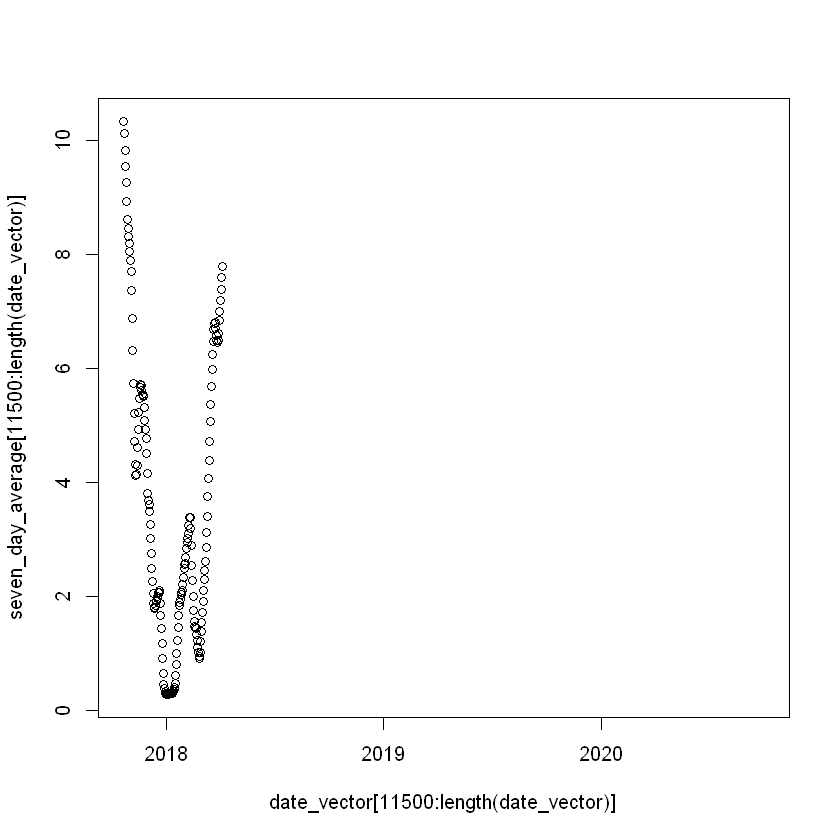

In [54]:
plot(date_vector[11500:length(date_vector)], seven_day_average[11500:length(date_vector)])

In [68]:
length(stream_temperature_data_x)

[1] 0

# ----------------------------------------------------------------------------------
#         Read in Data
# ----------------------------------------------------------------------------------

In [237]:
all_USGS_data = list() # creates a list

for(i in 1:nrow(USGS_sites)){
    
    year_start = '1980-01-01'
    year_end = '2020-10-01'
    
    # ---------------- read in data and add to master list (all_snotel_data) --------
    site_x = USGS_sites$USGS_site_no[i]
    if(site_x == 12439500){  # okanogan - orville site has "auxillary" data
        metric = 'mean2'
    }else{
        metric = 'mean'
    }
    
    # ---------------- read in data and add to master list (all_snotel_data) --------
    site_x = USGS_sites$USGS_site_no[i]
    if(site_x == 12442500){  # Okanogan - Similkameen (Nighthaw) has a couple years in 1980s, going to skip
        year_start = '1990-01-01'
    }
    
    print('starting download of....')
    print(site_x)
    all_USGS_data[[site_x]] = FXN_download_stream_temperature(USGS_sites$USGS_site_no[i],
                                                                                year_start, year_end, TRUE, metric)
    print("         DONE                 ")
    print("       ")
}


[1] "starting download of...."
[1] 12442500


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 9 columns (i.e. invalid file). Added 8 extra default column names at the end."


[1] "dimensions of data:"
[1] 2407    4
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12447200


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 9 columns (i.e. invalid file). Added 8 extra default column names at the end."
Warning message in FXN_download_stream_temperature(USGS_sites$USGS_site_no[i], year_start, :
"NAs introduced by coercion"


[1] "dimensions of data:"
[1] 5666    4
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12447390


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 9 columns (i.e. invalid file). Added 8 extra default column names at the end."


[1] "dimensions of data:"
[1] 3319    4
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12450480


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 9 columns (i.e. invalid file). Added 8 extra default column names at the end."


[1] "dimensions of data:"
[1] 2536    4
[1] "         DONE                 "
[1] "       "
[1] "starting download of...."
[1] 12462500


Warning message in fread(path_updated_x):
"Detected 1 column names but the data has 9 columns (i.e. invalid file). Added 8 extra default column names at the end."


[1] "dimensions of data:"
[1] 1511    4
[1] "         DONE                 "
[1] "       "


# ----------------------------------------------------------------------------------
#             Calculate Statistics
# ----------------------------------------------------------------------------------

In [238]:
# ------------ data frame for statistics ---------
stream_temperature_statistics_output = c()

for(i in 1:nrow(USGS_sites)){

    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(USGS_sites$USGS_site_no[i])
    site_x = USGS_sites$USGS_site_no[i]
    # ------------------------ generate the stream tempreature -------------------
    stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[site_x]]$'stream_temperature_degC' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime2'
    
    # ----------- clip "NAs" at the beginning -------
    x =!is.na(stream_temperature_data_x)
    x = which(x == TRUE)
    first_not_na = min(x)
    include_x = seq(first_not_na, length(stream_temperature_data_x))
    stream_temperature_data_x = stream_temperature_data_x[include_x]
    date_vector = date_vector[include_x]
    
    # ---------------- generate output data --------------
    output_data_x = USGS_stream_temperature_statistics(stream_temperature_data_x, date_vector, year_to_plot)
    sites_df = t(as.data.frame(c(USGS_sites$Site_name[i], USGS_sites$USGS_site_no[i])))
    colnames(sites_df) = c("site_name", "site_number")
    output_data_x = cbind(sites_df, output_data_x)
    rownames(output_data_x) = i
    stream_temperature_statistics_output = rbind(stream_temperature_statistics_output, output_data_x)
    
}
stream_temperature_statistics_output= as.data.frame(stream_temperature_statistics_output)
# -------- convert numbers from character to numeric -------
i = seq(2,ncol(stream_temperature_statistics_output))   
stream_temperature_statistics_output[ , i] = apply(stream_temperature_statistics_output[ , i], 2,function(x) as.numeric(as.character(x))) # convert numbers to numeric

[1] 1
[1] 12442500
[1] 2
[1] 12447200
[1] 3
[1] 12447390
[1] 4
[1] 12450480
[1] 5
[1] 12462500


In [239]:
stream_temperature_statistics_output[,8:10]

,average_peak_temperature_day_of_year,DELTA_peak_temperature_day_year_of_interest,years_with_sufficient_data_for_analysis
,<dbl>,<dbl>,<dbl>
1,214.50,8.50,6
2,218.07,-4.07,15
3,211.56,11.44,9
4,210.71,9.29,7
5,226.50,-4.50,4


In [240]:
i = 1
print(USGS_sites$USGS_site_no[i])
site_x = USGS_sites$USGS_site_no[i]
# ------------------------ generate the stream tempreature -------------------
stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[site_x]]$'stream_temperature_degC' ))
date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime2'

# ----------- clip "NAs" at the beginning -------
x =!is.na(stream_temperature_data_x)
x = which(x == TRUE)
first_not_na = min(x)
include_x = seq(first_not_na, length(stream_temperature_data_x))
stream_temperature_data_x = stream_temperature_data_x[include_x]
date_vector = date_vector[include_x]


# ---------------- generate output data --------------
output_data_x = USGS_stream_temperature_statistics(stream_temperature_data_x, date_vector, year_to_plot)
#sites_df = t(as.data.frame(c(USGS_sites$Site_name[i], USGS_sites$USGS_site_no[i])))
#colnames(sites_df) = c("site_name", "site_number")


[1] 12442500


In [204]:
paste( seq(1,length(colnames(stream_temperature_statistics_output))),
           colnames(stream_temperature_statistics_output) )

[1] "1 site_name"                                              
 [2] "2 site_number"                                            
 [3] "3 peak_temperature_7day_avg_year_of_interest_deg_C"       
 [4] "4 average_7day_avg_peak_temperature_deg_C"                
 [5] "5 PRCNT_peak_temperature_year_of_interest_deg_C"          
 [6] "6 DELTA_peak_temperature_year_of_interest_deg_C"          
 [7] "7 peak_temperature_day_year_of_interest"                  
 [8] "8 average_peak_temperature_day_of_year"                   
 [9] "9 DELTA_peak_temperature_day_year_of_interest"            
[10] "10 years_with_sufficient_data_for_analysis"               
[11] "11 low_temperature_7day_avg_year_of_interest_deg_C"       
[12] "12 average_7day_avg_low_temperature_deg_C"                
[13] "13 PRCNT_low_temperature_year_of_interest_deg_C"          
[14] "14 DELTA_low_temperature_year_of_interest_deg_C"          
[15] "15 low_temperature_day_year_of_interest"                  
[16] "16 average_low_temperature_day_of_year"                   
[17] "17 DELTA_low_temperature_day_year_of_interest"            
[18] "18 annual_total_temperature_year_of_interest_inches"      
[19] "19 mean_annual_total_temperature_inches"                  
[20] "20 PRCNT_annual_total_temperature_year_of_interest_inches"
[21] "21 DELTA_annual_total_temperature_year_of_interest_inches"
[22] "22 Jan_mean_temperature_year_of_interest_deg_C"           
[23] "23 Feb_mean_temperature_year_of_interest_deg_C"           
[24] "24 Mar_mean_temperature_year_of_interest_deg_C"           
[25] "25 Apr_mean_temperature_year_of_interest_deg_C"           
[26] "26 May_mean_temperature_year_of_interest_deg_C"           
[27] "27 Jun_mean_temperature_year_of_interest_deg_C"           
[28] "28 Jul_mean_temperature_year_of_interest_deg_C"           
[29] "29 Aug_mean_temperature_year_of_interest_deg_C"           
[30] "30 Sep_mean_temperature_year_of_interest_deg_C"           
[31] "31 Oct_mean_temperature_year_of_interest_deg_C"           
[32] "32 Nov_mean_temperature_year_of_interest_deg_C"           
[33] "33 Dec_mean_temperature_year_of_interest_deg_C"           
[34] "34 Jan_mean_temperature_all_years_deg_C"                  
[35] "35 Feb_mean_temperature_all_years_deg_C"                  
[36] "36 Mar_mean_temperature_all_years_deg_C"                  
[37] "37 Apr_mean_temperature_all_years_deg_C"                  
[38] "38 May_mean_temperature_all_years_deg_C"                  
[39] "39 Jun_mean_temperature_all_years_deg_C"                  
[40] "40 Jul_mean_temperature_all_years_deg_C"                  
[41] "41 Aug_mean_temperature_all_years_deg_C"                  
[42] "42 Sep_mean_temperature_all_years_deg_C"                  
[43] "43 Oct_mean_temperature_all_years_deg_C"                  
[44] "44 Nov_mean_temperature_all_years_deg_C"                  
[45] "45 Dec_mean_temperature_all_years_deg_C"                  
[46] "46 Jan_mean_PRCNT_temperature_year_of_interest_deg_C"     
[47] "47 Feb_mean_PRCNT_temperature_year_of_interest_deg_C"     
[48] "48 Mar_mean_PRCNT_temperature_year_of_interest_deg_C"     
[49] "49 Apr_mean_PRCNT_temperature_year_of_interest_deg_C"     
[50] "50 May_mean_PRCNT_temperature_year_of_interest_deg_C"     
[51] "51 Jun_mean_PRCNT_temperature_year_of_interest_deg_C"     
[52] "52 Jul_mean_PRCNT_temperature_year_of_interest_deg_C"     
[53] "53 Aug_mean_PRCNT_temperature_year_of_interest_deg_C"     
[54] "54 Sep_mean_PRCNT_temperature_year_of_interest_deg_C"     
[55] "55 Oct_mean_PRCNT_temperature_year_of_interest_deg_C"     
[56] "56 Nov_mean_PRCNT_temperature_year_of_interest_deg_C"     
[57] "57 Dec_mean_PRCNT_temperature_year_of_interest_deg_C"     
[58] "58 Jan_mean_DELTA_temperature_year_of_interest_deg_C"     
[59] "59 Feb_mean_DELTA_temperature_year_of_interest_deg_C"     
[60] "60 Mar_mean_DELTA_temperature_year_of_interest_deg_C"     
[61] "61 Apr_mean_DELTA_temperature_year_of_interest_deg_C"     
[62] "62 May_mean_DELTA_temperature_

In [218]:
i = c(1,7:9)
stream_temperature_statistics_output[,i]

,site_name,peak_temperature_day_year_of_interest,average_peak_temperature_day_of_year,DELTA_peak_temperature_day_year_of_interest
,<chr>,<dbl>,<dbl>,<dbl>
1,"OKANOGAN RIVER AT OROVILLE, WA",223,218.77,4.23
2,"OKANOGAN RIVER AT MALOTT, WA",214,218.07,-4.07
3,"ANDREWS CREEK NEAR MAZAMA, WA",223,211.56,11.44
4,"METHOW RIVER NEAR MOUTH NEAR PATEROS, WA",220,210.71,9.29
5,"WENATCHEE RIVER AT MONITOR, WA",222,226.50,-4.50


### ----------------------------------------------------------
###           statistics for peak temperature ABSOLUTE
### ----------------------------------------------------------

In [245]:
print('-----Maximum (deg C) -----:')
max(stream_temperature_statistics_output$peak_temperature_7day_avg_year_of_interest_deg_C)
print('-----Mean (deg C)  -----:')
round( mean(stream_temperature_statistics_output$peak_temperature_7day_avg_year_of_interest_deg_C),  2)
print('-----Minimum (deg C) -----:')
min(stream_temperature_statistics_output$peak_temperature_7day_avg_year_of_interest_deg_C)
print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$peak_temperature_7day_avg_year_of_interest_deg_C)  )
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$peak_temperature_7day_avg_year_of_interest_deg_C),  2)   )
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$peak_temperature_7day_avg_year_of_interest_deg_C)   )

[1] "-----Maximum (deg C) -----:"


[1] 24.3

[1] "-----Mean (deg C)  -----:"


[1] 20.53

[1] "-----Minimum (deg C) -----:"


[1] 12.89

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 75.74

[1] "-----Mean (deg F) -----:"


[1] 68.954

[1] "-----Minimum (deg F) -----:"


[1] 55.202

### ----------------------------------------------------------
###           statistics for peak temperature  PRCNT
###              NOTE: PRCNT doesn't make sense becuase of scale of temperature
### ----------------------------------------------------------

In [207]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$PRCNT_peak_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$PRCNT_peak_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$PRCNT_peak_temperature_year_of_interest_deg_C)

[1] "-----Maximum -----:"


[1] 110.66

[1] "-----Mean -----:"


[1] 103.49

[1] "-----Minimum -----:"


[1] 98.62

### ----------------------------------------------------------
###           statistics for peak temperature  DELTA
### ----------------------------------------------------------

In [247]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C)
print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C)  ) - 32
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C),  2)   ) - 32
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C)   ) - 32

[1] "-----Maximum -----:"


[1] 2.16

[1] "-----Mean -----:"


[1] 0.97

[1] "-----Minimum -----:"


[1] 0.13

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 3.888

[1] "-----Mean (deg F) -----:"


[1] 1.746

[1] "-----Minimum (deg F) -----:"


[1] 0.234

### ----------------------------------------------------------
###          Print all sites for peak temperature
### ----------------------------------------------------------

In [248]:
stream_temperature_statistics_output[,c('site_name', 'peak_temperature_7day_avg_year_of_interest_deg_C',
                                        'DELTA_peak_temperature_year_of_interest_deg_C',
                                       'peak_temperature_day_year_of_interest','DELTA_peak_temperature_day_year_of_interest')]


,site_name,peak_temperature_7day_avg_year_of_interest_deg_C,DELTA_peak_temperature_year_of_interest_deg_C,peak_temperature_day_year_of_interest,DELTA_peak_temperature_day_year_of_interest
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,"SIMILKAMEEN RIVER NEAR NIGHTHAWK, WA",21.53,1.15,223,8.50
2,"OKANOGAN RIVER AT MALOTT, WA",24.30,0.13,214,-4.07
3,"ANDREWS CREEK NEAR MAZAMA, WA",12.89,0.20,223,11.44
4,"METHOW RIVER NEAR MOUTH NEAR PATEROS, WA",21.44,1.22,220,9.29
5,"WENATCHEE RIVER AT MONITOR, WA",22.47,2.16,222,-4.50


In [263]:
deg_C_to_deg_F(24.30)

[1] 75.74

### ----------------------------------------------------------
###           statistics for number of years with sufficient data to analyze
### ----------------------------------------------------------

In [249]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$years_with_sufficient_data_for_analysis)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$years_with_sufficient_data_for_analysis),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$years_with_sufficient_data_for_analysis)

[1] "-----Maximum -----:"


[1] 15

[1] "-----Mean -----:"


[1] 8.2

[1] "-----Minimum -----:"


[1] 4

### ----------------------------------------------------------
###           statistics for peak temperature DAY for year of interest
### ----------------------------------------------------------

In [250]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$peak_temperature_day_year_of_interest)
as.Date(paste(max(stream_temperature_statistics_output$peak_temperature_day_year_of_interest), year_to_plot, sep="-" ),format='%j-%Y')
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$peak_temperature_day_year_of_interest),  1)
as.Date(paste(round( mean(stream_temperature_statistics_output$peak_temperature_day_year_of_interest),  0), year_to_plot, sep="-" ),format='%j-%Y')

print('-----Minimum -----:')
min(stream_temperature_statistics_output$peak_temperature_day_year_of_interest)
as.Date(paste(min(stream_temperature_statistics_output$peak_temperature_day_year_of_interest), year_to_plot, sep="-" ),format='%j-%Y')


[1] "-----Maximum -----:"


[1] 223

[1] "2019-08-11"

[1] "-----Mean -----:"


[1] 220.4

[1] "2019-08-08"

[1] "-----Minimum -----:"


[1] 214

[1] "2019-08-02"

### ----------------------------------------------------------
###           statistics for peak temperature DAY DELTA
### ----------------------------------------------------------

In [251]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$DELTA_peak_temperature_day_year_of_interest)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$DELTA_peak_temperature_day_year_of_interest),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$DELTA_peak_temperature_day_year_of_interest)

[1] "-----Maximum -----:"


[1] 11.44

[1] "-----Mean -----:"


[1] 4.13

[1] "-----Minimum -----:"


[1] -4.5

### ----------------------------------------------------------
###           statistics for peak temperature July year of interest
### ----------------------------------------------------------

In [256]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$Jul_mean_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$Jul_mean_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$Jul_mean_temperature_year_of_interest_deg_C)

print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C)  ) 
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C),  2)   )
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$DELTA_peak_temperature_year_of_interest_deg_C)   ) 

[1] "-----Maximum -----:"


[1] 22.4

[1] "-----Mean -----:"


[1] 18.08

[1] "-----Minimum -----:"


[1] 11.1

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 35.888

[1] "-----Mean (deg F) -----:"


[1] 33.746

[1] "-----Minimum (deg F) -----:"


[1] 32.234

### ----------------------------------------------------------
###           statistics for peak temperature July DELTA
### ----------------------------------------------------------

In [257]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$Jul_mean_DELTA_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$Jul_mean_DELTA_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$Jul_mean_DELTA_temperature_year_of_interest_deg_C)
print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$Jul_mean_DELTA_temperature_year_of_interest_deg_C)  ) - 32
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$Jul_mean_DELTA_temperature_year_of_interest_deg_C),  2)   ) - 32
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$Jul_mean_DELTA_temperature_year_of_interest_deg_C)   ) - 32

[1] "-----Maximum -----:"


[1] 0.73

[1] "-----Mean -----:"


[1] 0.06

[1] "-----Minimum -----:"


[1] -0.76

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 1.314

[1] "-----Mean (deg F) -----:"


[1] 0.108

[1] "-----Minimum (deg F) -----:"


[1] -1.368

### ----------------------------------------------------------
###           statistics for peak temperature August year of interest
### ----------------------------------------------------------

In [255]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$Aug_mean_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$Aug_mean_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$Aug_mean_temperature_year_of_interest_deg_C)

print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$Aug_mean_temperature_year_of_interest_deg_C)  ) 
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$Aug_mean_temperature_year_of_interest_deg_C),  2)   )
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$Aug_mean_temperature_year_of_interest_deg_C)   ) 

[1] "-----Maximum -----:"


[1] 23

[1] "-----Mean -----:"


[1] 19.38

[1] "-----Minimum -----:"


[1] 12.1

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 73.4

[1] "-----Mean (deg F) -----:"


[1] 66.884

[1] "-----Minimum (deg F) -----:"


[1] 53.78

### ----------------------------------------------------------
###          statistics for peak temperature August DELTA
### ----------------------------------------------------------

In [258]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$Aug_mean_DELTA_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$Aug_mean_DELTA_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$Aug_mean_DELTA_temperature_year_of_interest_deg_C)
print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$Aug_mean_DELTA_temperature_year_of_interest_deg_C)  ) - 32
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$Aug_mean_DELTA_temperature_year_of_interest_deg_C),  2)   ) - 32
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$Aug_mean_DELTA_temperature_year_of_interest_deg_C)   ) - 32

[1] "-----Maximum -----:"


[1] 1.17

[1] "-----Mean -----:"


[1] 0.68

[1] "-----Minimum -----:"


[1] 0.3

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 2.106

[1] "-----Mean (deg F) -----:"


[1] 1.224

[1] "-----Minimum (deg F) -----:"


[1] 0.54

### ----------------------------------------------------------
###           statistics for peak temperature September year of interest
### ----------------------------------------------------------

In [259]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$Sep_mean_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$Sep_mean_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$Sep_mean_temperature_year_of_interest_deg_C)

print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$Sep_mean_temperature_year_of_interest_deg_C)  ) 
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$Sep_mean_temperature_year_of_interest_deg_C),  2)   )
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$Sep_mean_temperature_year_of_interest_deg_C)   ) 

[1] "-----Maximum -----:"


[1] 18.5

[1] "-----Mean -----:"


[1] 15.34

[1] "-----Minimum -----:"


[1] 9.4

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 65.3

[1] "-----Mean (deg F) -----:"


[1] 59.612

[1] "-----Minimum (deg F) -----:"


[1] 48.92

### ----------------------------------------------------------
###           statistics for peak temperature September DELTA
### ----------------------------------------------------------

In [260]:
print('-----Maximum -----:')
max(stream_temperature_statistics_output$Sep_mean_DELTA_temperature_year_of_interest_deg_C)
print('-----Mean -----:')
round( mean(stream_temperature_statistics_output$Sep_mean_DELTA_temperature_year_of_interest_deg_C),  2)
print('-----Minimum -----:')
min(stream_temperature_statistics_output$Sep_mean_DELTA_temperature_year_of_interest_deg_C)
print( '----------------------------------------------')
print('-----Maximum (deg F) -----:')
deg_C_to_deg_F(  max(stream_temperature_statistics_output$Sep_mean_DELTA_temperature_year_of_interest_deg_C)  ) - 32
print('-----Mean (deg F) -----:')
deg_C_to_deg_F(   round( mean(stream_temperature_statistics_output$Sep_mean_DELTA_temperature_year_of_interest_deg_C),  2)   ) - 32
print('-----Minimum (deg F) -----:')
deg_C_to_deg_F(   min(stream_temperature_statistics_output$Sep_mean_DELTA_temperature_year_of_interest_deg_C)   ) - 32

[1] "-----Maximum -----:"


[1] 1.02

[1] "-----Mean -----:"


[1] 0.62

[1] "-----Minimum -----:"


[1] 0.37

[1] "----------------------------------------------"
[1] "-----Maximum (deg F) -----:"


[1] 1.836

[1] "-----Mean (deg F) -----:"


[1] 1.116

[1] "-----Minimum (deg F) -----:"


[1] 0.666

# ----------------------------------------------------------
#           PLOT
# ----------------------------------------------------------

In [325]:
# options(repr.plot.width=2, repr.plot.height=4)

# Opening the graphical device
pdf(path_output, width = 7, height = 9)


par(mfrow=c(4, 2), oma=c(0.5, 0.8, 0, 0.8), mar=c(3.5, 5, 3, 0.5),  xpd=FALSE)

for(i in 1:nrow(USGS_sites)){

    
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( i == 1){
        plot.new()
        par(xpd=TRUE)
        plot.new()
        legend("bottomright", inset=c(0,-0.2), legend=c("median stream T",   paste("stream T in", year_to_plot, sep=" "), "stream T = 65 deg F" ), 
        lty=c(1, 1, 2), title="Legend", col=c("black","blue", "red"), lwd=c(2.1, 1.4, 1.2), seg.len = 3, cex=1.4)
        
    }
    par(xpd=FALSE)
    
    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(USGS_sites$USGS_site_no[i])
    # ------------------------ generate the median snotel -------------------
    stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'stream_temperature_degC' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime'
    date_vector = as.POSIXct(date_vector, format="%Y-%m-%d") #  convert to date time 
    
    # ------------------------ generate the median snotel -------------------
    median_stream_temperature_data_x = median_stream_temperature_function(stream_temperature_data_x, date_vector, year_to_plot)

    # --------------- convert to deg F -----------------
    stream_temperature_data_x = deg_C_to_deg_F(stream_temperature_data_x)
    median_stream_temperature_data_x$metric = deg_C_to_deg_F(median_stream_temperature_data_x$metric )
    
    # ------------------------------------------------------------
    #         Plot the Data
    # ------------------------------------------------------------
    max_ylim = max(median_stream_temperature_data_x$metric, na.rm=T) 
    max_ylim = max_ylim + max_ylim*0.1
    max_ylim = 77 # just over-ride and set to 75
    
    #xlim_min = as.Date(paste('10-01-',year_to_plot-1, sep=""), format = '%m-%d-%Y')
    #xlim_max = as.Date(paste('09-30-',year_to_plot, sep=""), format = '%m-%d-%Y')

    plot(median_stream_temperature_data_x$day_of_hydro_year[order(median_stream_temperature_data_x$day_of_hydro_year)],
         median_stream_temperature_data_x$metric[order(median_stream_temperature_data_x$day_of_hydro_year)] , 
         type='l', col='black', lwd=2,
        xlab=' ',ylab='stream temperature  \n (deg F)', ylim=c(31, max_ylim), 
        xlim=c(min(median_stream_temperature_data_x$day_of_hydro_year) + 86400 * 2 , max(median_stream_temperature_data_x$day_of_hydro_year)  - 86400 * 2 ) )
    grid(lwd=1.5)
    abline(h=64.4, lwd=1.2, col='red', lty=2) # water temperatures above 18 deg C can be harmful to salmon
    lines(median_stream_temperature_data_x$day_of_hydro_year[order(median_stream_temperature_data_x$day_of_hydro_year)],
         median_stream_temperature_data_x$metric[order(median_stream_temperature_data_x$day_of_hydro_year)], col='black',lwd=2.2)
    
    mtext(USGS_sites$Site_name[i], side=3, line=0.3, font=2, cex=0.95)
    
    lines(date_vector, stream_temperature_data_x, lwd=1.4, col='blue', lty=1)

    # ------------------------------------------------------------
    #      Insert title
    # ------------------------------------------------------------
    
    if(i == 1){
        
        year_span = paste(year_to_plot-1,year_to_plot,sep=" - Dec ")
        mtext( paste("                    Stream Temperature in Upper Columbia \n from Jan - Dec 2019 ", sep="") , side=3, line=9, cex=1.7, font=4)
        
    }
    
    # ------------------------------------------------------------
    #      Insert legend
    # ------------------------------------------------------------
    
    
    if(i ==2){
        
        #legend("topright", inset=c(0,-0.3), legend=c("median stream temp", paste("stream temp in", year_to_plot, sep=" ") ), 
        #       lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5))
        
    }
    
    # ------------------------------------------------------------
    #      Add Watershed Name
    # ------------------------------------------------------------
    
    if(i == 1){
        # mtext('                                                 Okanogan', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Okanogan - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 3){
        #mtext('                                                 Methow', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Methow - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 5){
        #mtext('                                                 Wenatchee', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                             - - - - - - Wenatchee - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }
        
 
}




# Closing the graphical device
dev.off()


[1] 1
[1] 12442500
[1] 2
[1] 12447200
[1] 3
[1] 12447390
[1] 4
[1] 12450480
[1] 5
[1] 12462500


png 
  2

[1] 1
[1] 12442500
[1] 2
[1] 12447200
[1] 3
[1] 12447390
[1] 4
[1] 12450480
[1] 5
[1] 12462500


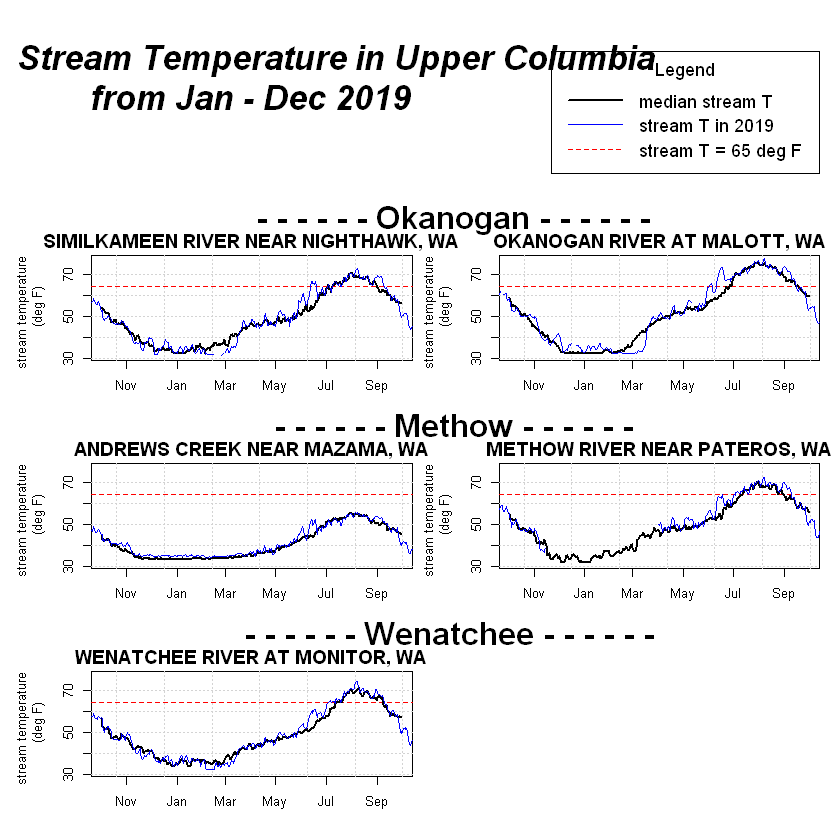

In [326]:
# options(repr.plot.width=2, repr.plot.height=4)


par(mfrow=c(4, 2), oma=c(0.5, 0.8, 0, 0.8), mar=c(3.5, 5, 3, 0.5),  xpd=FALSE)

for(i in 1:nrow(USGS_sites)){

    
    # ------------------------------------------------------------
    #        put blank plot in Entiat (since only one)
    # ------------------------------------------------------------

    if( i == 1){
        plot.new()
        par(xpd=TRUE)
        plot.new()
        legend("bottomright", inset=c(0,-0.2), legend=c("median stream T",   paste("stream T in", year_to_plot, sep=" "), "stream T = 65 deg F" ), 
        lty=c(1, 1, 2), title="Legend", col=c("black","blue", "red"), lwd=c(2.1, 1.4, 1.2), seg.len = 3, cex=1.4)
        
    }
    par(xpd=FALSE)
    
    # ------------------------------------------------------------
    #          Prepare the Data
    # ------------------------------------------------------------
    print(i)
    print(USGS_sites$USGS_site_no[i])
    # ------------------------ generate the median snotel -------------------
    stream_temperature_data_x = as.numeric(as.character(all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'stream_temperature_degC' ))
    date_vector = all_USGS_data[[as.numeric(USGS_sites$USGS_site_no[i])]]$'datetime'
    date_vector = as.POSIXct(date_vector, format="%Y-%m-%d") #  convert to date time 
    
    # ------------------------ generate the median snotel -------------------
    median_stream_temperature_data_x = median_stream_temperature_function(stream_temperature_data_x, date_vector, year_to_plot)

    # --------------- convert to deg F -----------------
    stream_temperature_data_x = deg_C_to_deg_F(stream_temperature_data_x)
    median_stream_temperature_data_x$metric = deg_C_to_deg_F(median_stream_temperature_data_x$metric )
    
    # ------------------------------------------------------------
    #         Plot the Data
    # ------------------------------------------------------------
    max_ylim = max(median_stream_temperature_data_x$metric, na.rm=T) 
    max_ylim = max_ylim + max_ylim*0.1
    max_ylim = 77 # just over-ride and set to 75
    
    #xlim_min = as.Date(paste('10-01-',year_to_plot-1, sep=""), format = '%m-%d-%Y')
    #xlim_max = as.Date(paste('09-30-',year_to_plot, sep=""), format = '%m-%d-%Y')

    plot(median_stream_temperature_data_x$day_of_hydro_year[order(median_stream_temperature_data_x$day_of_hydro_year)],
         median_stream_temperature_data_x$metric[order(median_stream_temperature_data_x$day_of_hydro_year)] , 
         type='l', col='black', lwd=2,
        xlab=' ',ylab='stream temperature  \n (deg F)', ylim=c(31, max_ylim), 
        xlim=c(min(median_stream_temperature_data_x$day_of_hydro_year) + 86400 * 2 , max(median_stream_temperature_data_x$day_of_hydro_year)  - 86400 * 2 ) )
    grid(lwd=1.5)
    abline(h=64.4, lwd=1.2, col='red', lty=2) # water temperatures above 18 deg C can be harmful to salmon
    lines(median_stream_temperature_data_x$day_of_hydro_year[order(median_stream_temperature_data_x$day_of_hydro_year)],
         median_stream_temperature_data_x$metric[order(median_stream_temperature_data_x$day_of_hydro_year)], col='black',lwd=2.2)
    
    mtext(USGS_sites$Site_name[i], side=3, line=0.3, font=2, cex=0.95)
    
    lines(date_vector, stream_temperature_data_x, lwd=1.4, col='blue', lty=1)

    # ------------------------------------------------------------
    #      Insert title
    # ------------------------------------------------------------
    
    if(i == 1){
        
        year_span = paste(year_to_plot-1,year_to_plot,sep=" - Dec ")
        mtext( paste("                    Stream Temperature in Upper Columbia \n from Jan - Dec 2019 ", sep="") , side=3, line=9, cex=1.7, font=4)
        
    }
    
    # ------------------------------------------------------------
    #      Insert legend
    # ------------------------------------------------------------
    
    
    if(i ==2){
        
        #legend("topright", inset=c(0,-0.3), legend=c("median stream temp", paste("stream temp in", year_to_plot, sep=" ") ), 
        #       lty=c(1, 2), title="Legend", col=c("black","blue"), lwd=c(2, 2.5))
        
    }
    
    # ------------------------------------------------------------
    #      Add Watershed Name
    # ------------------------------------------------------------
    
    if(i == 1){
        # mtext('                                                 Okanogan', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Okanogan - - - - - - ', side=3, line=1.5, font=2, cex=1.6)

    }else if(i == 3){
        #mtext('                                                 Methow', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                              - - - - - - Methow - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }else if(i == 5){
        #mtext('                                                 Wenatchee', side=3, line=1.5, font=2, cex=1.6)
        mtext('                                             - - - - - - Wenatchee - - - - - - ', side=3, line=1.5, font=2, cex=1.6)
    }
        
 
}




In [312]:
deg_C_to_deg_F(18)

[1] 64.4